Loaded LHC with shape: (8500, 20), (8500, 800)
Loaded covariance with shape: (800, 800)


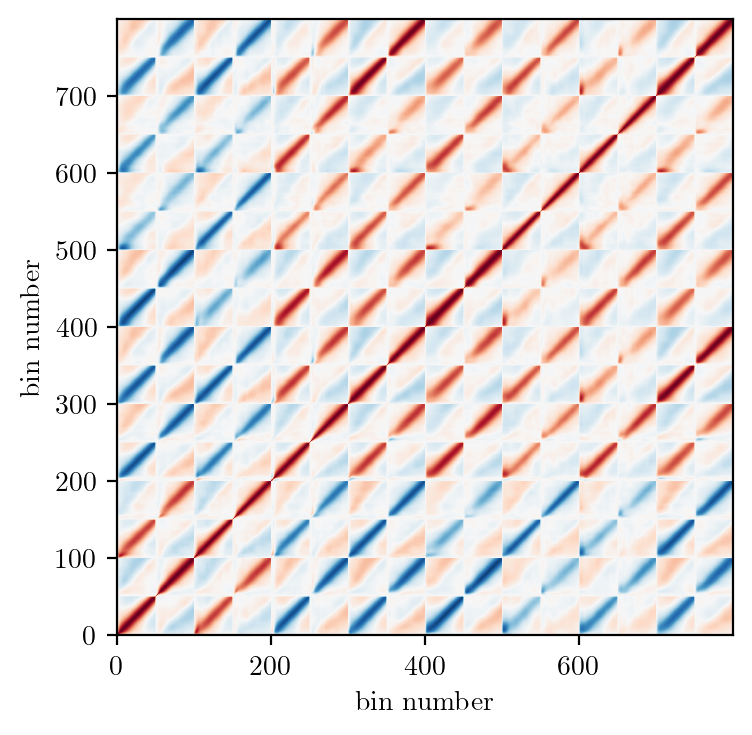

In [76]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy.stats import sigma_clip
from sunbird.emulators import FCN
import torch
import matplotlib
import matplotlib.pyplot as plt
import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_lhc(statistic='dsc_conf', return_sep=True):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x']
    lhc_x_names = data['lhc_x_names']
    lhc_y = data['lhc_y']
    s = data['k'] if statistic == 'pk' else data['s']
    if return_sep:
        return s, lhc_x, lhc_y, lhc_x_names
    return lhc_x, lhc_y

def read_covariance(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
    y = np.load(data_fn, allow_pickle=True).item()['cov_y']
    prefactor = 1 / 8
    cov = prefactor * np.cov(y, rowvar=False)
    corr = np.corrcoef(y, rowvar=False)
    return cov, corr

def read_model(statistic):
    if statistic == 'wp':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wp/cosmo+hod/jul10_trans/last-v30.ckpt'
    if statistic == 'pk':
        # checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/pk/cosmo+hod/aug8_asinh/last-v1.ckpt'
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/pk/cosmo+hod/aug8/last.ckpt'
    elif statistic == 'tpcf':
        # checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/cosmo+hod/jul9/last.ckpt'
        # checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/cosmo+hod/aug6/last.ckpt'
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/cosmo+hod/aug8_asinh/last.ckpt'
    elif statistic == 'dsc_conf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_conf/cosmo+hod/aug9/last.ckpt'
    elif statistic == 'dsc_fourier':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_fourier/jun24_leaveout_0/last-v1.ckpt'
    elif statistic == 'wst':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wst/jun27_leaveout_0/last.ckpt'
    elif statistic == 'minkowski':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/minkowski/Minkowski-best-model-epoch=276-val_loss=0.02366.ckpt'
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    return model

statistic = 'dsc_conf'

covariance_matrix, correlation_matrix = read_covariance(statistic=statistic)
s, lhc_x, lhc_y, lhc_x_names = read_lhc(return_sep=True, statistic=statistic)
model = read_model(statistic=statistic)
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')
print(f'Loaded covariance with shape: {covariance_matrix.shape}')

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(correlation_matrix, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('bin number')
ax.set_ylabel('bin number')
plt.show()

In [77]:
def get_emulator_error(lhc_test_y, pred_test_y):
    return np.median(np.abs(lhc_test_y - pred_test_y), axis=0)


lhc_train_x = lhc_x[600:]
lhc_train_y = lhc_y[600:]
lhc_test_x = lhc_x[:600]
lhc_test_y = lhc_y[:600]

with torch.no_grad():
    pred_test_y = model.get_prediction(torch.Tensor(lhc_test_x))
    pred_test_y = pred_test_y.numpy()

emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(s, s**1 * lhc_test_y[30][:len(s)], marker='o', ls='')
ax.plot(s, s**1 * pred_test_y[30][:len(s)])
ax.set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
# ax.set_ylabel(r'$s^2\xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.show()
    
fig, ax = plt.subplots(figsize=(5.5, 4))
cmap = matplotlib.colormaps['coolwarm']

# colors = cmap(np.linspace(0.01, 0.99, 5))
# for i, q in enumerate([0, 1, 3, 4]):
#     xrange = slice(2 * i * len(s), 2 * (i + 1) * len(s))
ax.fill_between(list(range(emulator_error.shape[1])), q68[0], q68[1],
                alpha=0.5, label=rf'$68\%$')
ax.legend()
ax.set_xlabel('bin number', fontsize=15)
ax.set_ylabel('(model - test)/sigma', fontsize=15)
ax.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm diffsky}$', fontsize=15)
plt.show()

fig, ax = plt.subplots()
emulator_error = get_emulator_error(pred_test_y, lhc_test_y)
ax.plot(emulator_error/np.sqrt(np.diag(covariance_matrix)))
plt.show()

ValueError: operands could not be broadcast together with shapes (600,400) (600,800) 

Transforming output


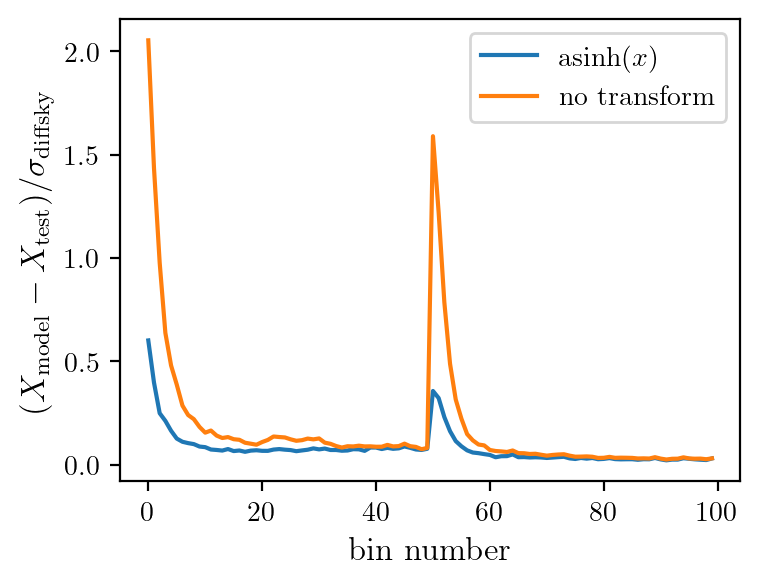

In [25]:
def get_emulator_error(lhc_test_y, pred_test_y):
    return np.median(np.abs(lhc_test_y - pred_test_y), axis=0)

fig, ax = plt.subplots(figsize=(4, 3))

lhc_train_x = lhc_x[600:]
lhc_train_y = lhc_y[600:]
lhc_test_x = lhc_x[:600]
lhc_test_y = lhc_y[:600]

with torch.no_grad():
    pred_test_y = model.get_prediction(torch.Tensor(lhc_test_x))
    pred_test_y = pred_test_y.numpy()

emulator_error = get_emulator_error(pred_test_y, lhc_test_y)
ax.plot(emulator_error/np.sqrt(np.diag(covariance_matrix)), label=r'$\textrm{asinh}(x)$')

with torch.no_grad():
    pred_test_y = model2.get_prediction(torch.Tensor(lhc_test_x))
    pred_test_y = pred_test_y.numpy()

emulator_error = get_emulator_error(pred_test_y, lhc_test_y)
ax.plot(emulator_error/np.sqrt(np.diag(covariance_matrix)), label=r'$\textrm{no transform}$')

ax.set_xlabel('bin number', fontsize=12)
ax.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm diffsky}$', fontsize=12)
ax.legend()
plt.show()